In [34]:
#前置作業 : 各種import、設定SEED

In [35]:
%%capture
"""
在Python中，%%capture 是一個魔術命令（Magic Command），用於捕獲並抑制輸出。
比如說，這樣寫的話下面安裝的過程就會被隱藏。
"""
!pip install geopandas folium

In [36]:
import pandas as pd
import numpy as np
import random
import os
from tqdm.notebook import tqdm

import geopandas as gpd
from shapely.geometry import Point
import folium

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
pd.options.display.float_format = '{:.5}'.format #小數點後保留5位
pd.options.display.max_rows = None

%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # You can ignore the Shapely GEOS warning :-)

In [37]:
#set seed for reproducability
SEED = 2023
random.seed(SEED)
np.random.seed(SEED)

In [38]:
#Loading and previewing data

In [39]:
DATA_PATH = 'D:/kaggle/input4'
#Load files
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
samplesubmission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

#Preview train dataset
train.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.00010834,0.60302,-6.5331e-05,0.25567,-98.594,...,3664.4,6.1086e+04,2615.1,15.569,0.27229,-12.629,35.632,-138.79,30.752,3.751
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,2.0527e-05,0.72821,1.361e-05,0.13099,16.593,...,3651.2,6.6969e+04,3174.6,8.6906,0.25683,30.359,39.558,-145.18,27.252,4.0252
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.00051414,0.7482,0.00038468,0.11002,72.796,...,4217.0,6.0069e+04,3516.3,21.103,0.2511,15.378,30.402,-142.52,26.193,4.2314
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.5,5.1065e+04,4181.0,15.387,0.26204,-11.293,24.38,-132.67,28.829,4.3053
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-7.8766e-05,0.6763,-4.7624e-05,0.12116,4.1213,...,3980.6,6.3751e+04,3355.7,8.1147,0.23585,38.532,37.393,-141.51,22.205,4.3473


In [40]:
train.shape, test.shape, samplesubmission.shape

((79023, 76), (24353, 75), (24353, 2))

In [41]:
#Train to test sets ratio
(test.shape[0])/(train.shape[0]+test.shape[0])

0.23557692307692307

In [42]:
#Statistical summaries

In [43]:
#Train statistical summary
train.describe(include = 'all')

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
count,79023,7.9023e+04,7.9023e+04,7.9023e+04,7.9023e+04,6.4414e+04,6.4414e+04,6.4414e+04,6.4414e+04,6.4414e+04,...,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.8539e+04,7.9023e+04
unique,79023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_-0.510_29.290_2019_00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,-1.8911,29.88,2020.0,26.0,4.7882e-05,0.83485,3.5049e-05,0.15842,-7.9259,...,5592.4,5.942e+04,4670.4,19.139,0.27146,-10.785,40.437,-86.801,27.926,81.941
std,NaN,0.69452,0.81038,0.8165,15.297,0.00027203,0.18538,0.00020559,0.071364,64.263,...,1428.5,9051.2,1359.3,13.547,0.049434,30.374,6.4282,37.837,4.4038,144.3
min,NaN,-3.299,28.228,2019.0,0.0,-0.00099624,0.24182,-0.00088714,0.0,-179.54,...,1050.7,2.4779e+04,1050.5,1.8445,0.017697,-102.74,2.9989,-153.46,10.818,0.0
25%,NaN,-2.451,29.262,2019.0,13.0,-9.5833e-05,0.70582,-7.7857e-05,0.11053,-56.782,...,4595.4,5.3176e+04,3680.9,9.9746,0.24145,-30.309,35.83,-125.99,24.687,9.798
50%,NaN,-1.882,29.883,2020.0,26.0,2.3694e-05,0.80912,1.8628e-05,0.16185,-12.442,...,5573.9,5.9333e+04,4621.8,15.131,0.27275,-12.674,41.12,-84.644,28.334,45.593
75%,NaN,-1.303,30.471,2021.0,39.0,0.00015305,0.94279,0.00012068,0.21182,72.06,...,6542.3,6.5664e+04,5573.0,23.785,0.30289,9.4022,44.446,-48.133,31.5,109.55


In [44]:
train.drop_duplicates(subset = ['year', 'week_no']).groupby(['year'])[['week_no']].count()

,week_no
year,
2019,53
2020,53
2021,53


In [45]:
#Correlations - EDA

In [46]:
"""
這一段程式碼非常重要，因為它顯示出前20個跟emission最相關的幾個特徵。
"""
#Top 20 correlated features to the target
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)
top20_corrs

emission                                                        1.0
longitude                                                   0.10275
UvAerosolLayerHeight_aerosol_height                        0.069008
UvAerosolLayerHeight_aerosol_pressure                      0.068138
Cloud_surface_albedo                                       0.046587
CarbonMonoxide_H2O_column_number_density                   0.043217
CarbonMonoxide_CO_column_number_density                    0.041328
Formaldehyde_tropospheric_HCHO_column_number_density_amf   0.040263
UvAerosolLayerHeight_aerosol_optical_depth                 0.040156
UvAerosolLayerHeight_sensor_azimuth_angle                  0.035142
NitrogenDioxide_solar_azimuth_angle                        0.033417
Formaldehyde_tropospheric_HCHO_column_number_density       0.033333
SulphurDioxide_solar_azimuth_angle                         0.032338
Formaldehyde_solar_azimuth_angle                           0.030815
NitrogenDioxide_sensor_altitude                 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


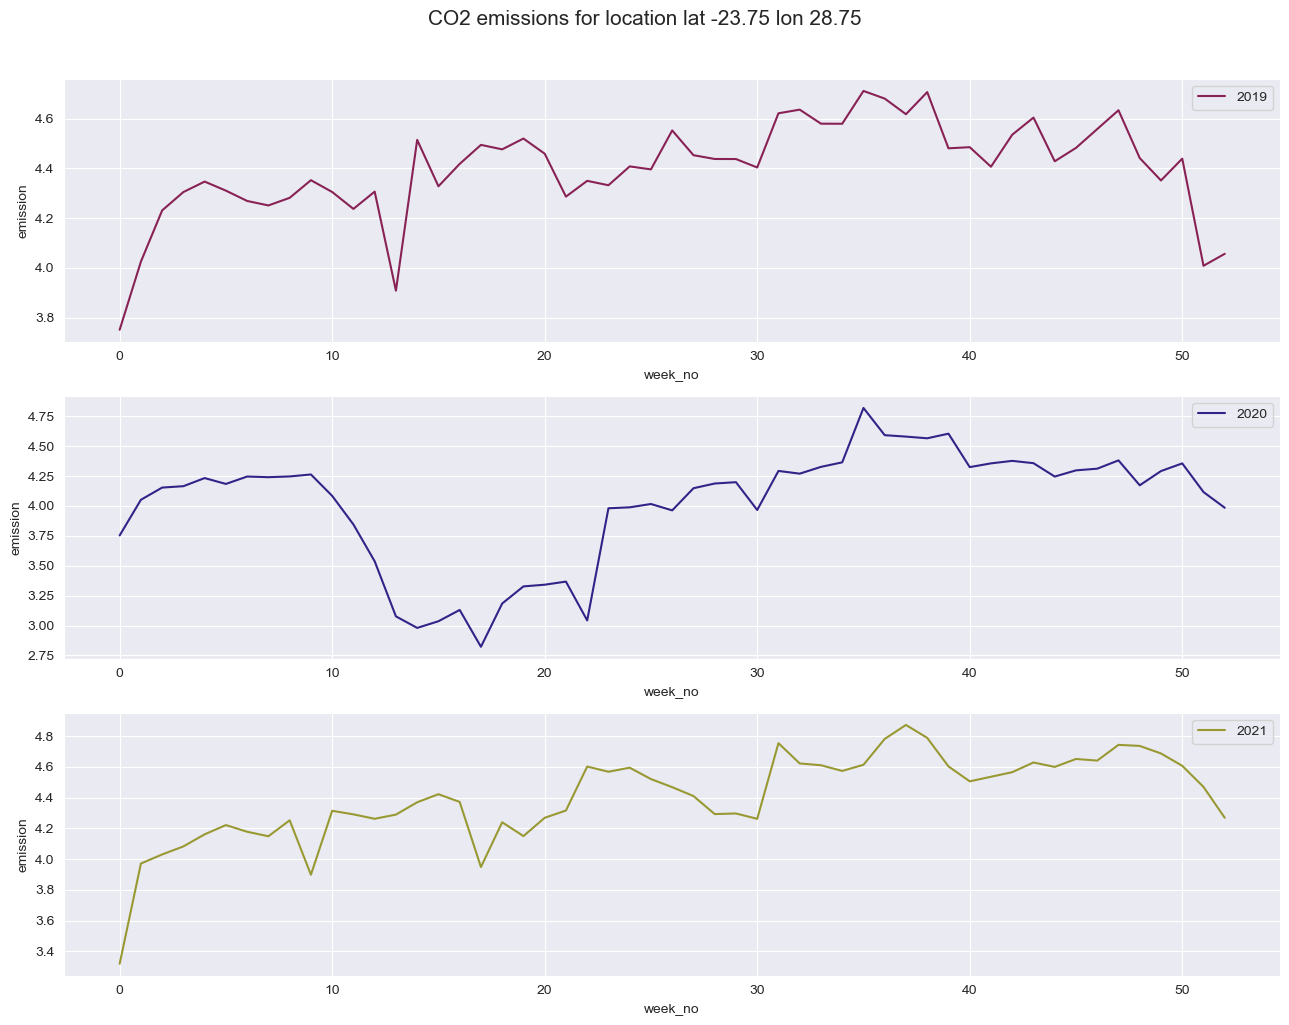

In [47]:
#Sample a unique location and visualize its emissions across the years
train.latitude, train.longtitude = round(train.latitude, 2), round(train.longitude, 2)
sample_loc = train[(train.latitude == -0.510) & (train.longitude == 29.290)] #這是train前5筆資造裡面看到的一個地點

#Plot a line plot
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (13, 10))
fig.suptitle('CO2 emissions for location lat -23.75 lon 28.75', y= 1.02, fontsize = 15)

#注意這裡zip是一一對應，像拉鍊一樣
for ax, data, year, color, in zip(axes.flatten(), sample_loc, sample_loc.year.unique(), ['#882255','#332288','#999933','orangered']):
    df = sample_loc[sample_loc.year == year]
    sns.lineplot(x=df.week_no, y=df.emission, ax = ax, label = year, color = color)
    plt.legend()
    plt.tight_layout()

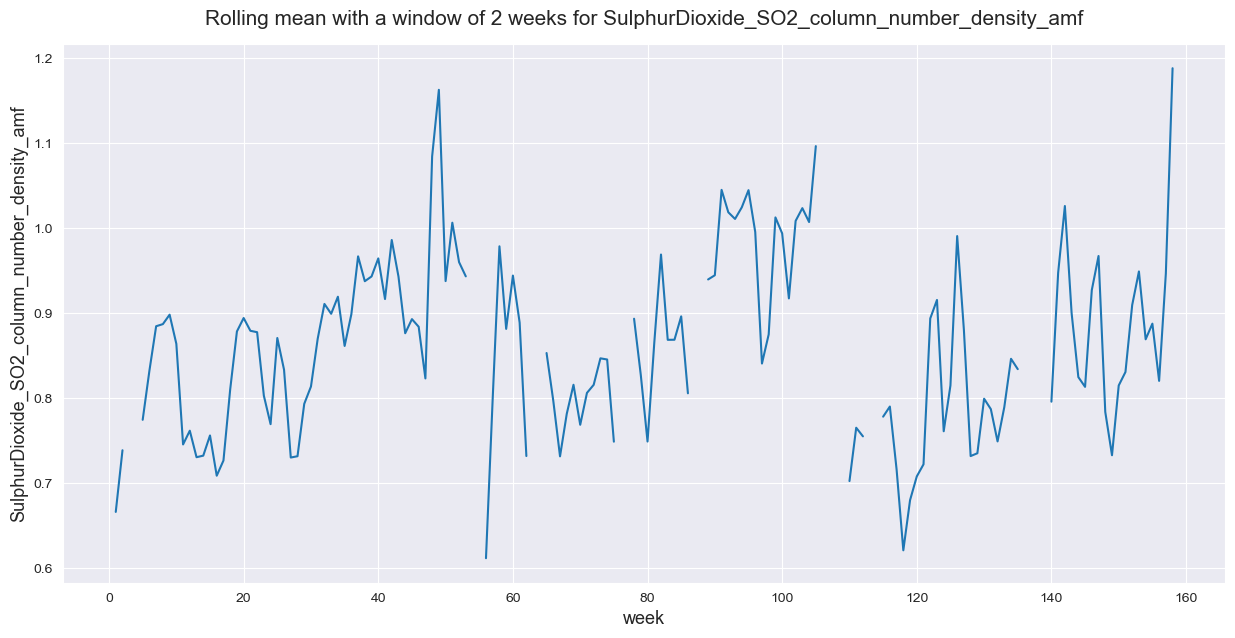

In [48]:
"""
注意，我們從EDA開始，畫出CO2的emission一直都只有單一地點而已，但我們實際上需要多個地點。
"""
#特徵工程的例子 : Aggregations, cumulative differences, moving averages ...
# 讓我們探索滾動平均值
#首先創造一個unique的經緯度，就是train再額外加一個欄叫做'location'.
train['location'] = [str(x) + '_' + str(y) for x, y in zip(train.latitude, train.longitude)]

#基於地點的filter，也就是說我要找特定地點的observation作為example
example_loc = train[train.location == '-0.51_29.29'] 
#我只取'-0.51_29.29'
#我有點擔心我們將經緯度只留下小數點後兩位的做法會讓我們在查詢的時候漏掉一些點

# Calculate rolling mean for SulphurDioxide_SO2_column_number_density_amf with a window of 2 weeks
"""重要程式碼: 計算rolling mean的方法!!!"""
rolling_mean = example_loc['SulphurDioxide_SO2_column_number_density_amf'].rolling(window = 2).mean()

# Visualing rolling mean
plt.figure(figsize = (15, 7))
rolling_mean.plot()
plt.title('Rolling mean with a window of 2 weeks for SulphurDioxide_SO2_column_number_density_amf', y = 1.02, fontsize = 15)
plt.xlabel('week', y =1.05, fontsize = 13)
plt.ylabel('SulphurDioxide_SO2_column_number_density_amf', x = 1.05, fontsize = 13)
plt.show()

In [49]:
"""
這裡最難懂!!!
"""
# Generate the above feature - rolling mean for all locations for both the train and test

#Feature engineering train
"""這一列不懂"""
train_roll_mean = train.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[train.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
               
"""這一列不懂"""
train_roll_mean.drop(['level_1', 'emission', 'location'], axis = 1, inplace = True)
#下面這一列程式碼增加各種氣體在特定week_no滾動平均的欄位:
train_roll_mean.columns = [col + '_roll_mean' for col in train_roll_mean.columns] 

# Feature engineering test
test.latitude, test.longitude = round(test.latitude, 2), round(test.longitude, 2)
test['location'] = [str(x) + '_' + str(y) for x, y in zip(test.latitude, test.longitude)]
"""這一列不懂"""
test_roll_mean = test.sort_values(by = ['location', 'year', 'week_no']).groupby(['location'])[test.columns[5:].tolist()].rolling(window = 2).mean().reset_index()
"""這一列不懂"""
test_roll_mean.drop(['level_1', 'location'], axis = 1, inplace = True)
#下面這一列程式碼增加各種氣體在特定week_no滾動平均的欄位:
test_roll_mean.columns =  [col + '_roll_mean' for col in test_roll_mean.columns]
test_roll_mean.head()

,SulphurDioxide_SO2_column_number_density_roll_mean,SulphurDioxide_SO2_column_number_density_amf_roll_mean,SulphurDioxide_SO2_slant_column_number_density_roll_mean,SulphurDioxide_cloud_fraction_roll_mean,SulphurDioxide_sensor_azimuth_angle_roll_mean,SulphurDioxide_sensor_zenith_angle_roll_mean,SulphurDioxide_solar_azimuth_angle_roll_mean,SulphurDioxide_solar_zenith_angle_roll_mean,SulphurDioxide_SO2_column_number_density_15km_roll_mean,CarbonMonoxide_CO_column_number_density_roll_mean,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.2281e+04,7474.2,4.7982e+04,6474.2,9.692,0.26695,-65.312,38.05,-135.84,32.396
2,0.00030824,0.64814,0.0002107,0.039935,17.092,27.745,-138.72,29.475,0.00010515,0.037718,...,4.1336e+04,7730.5,4.6961e+04,6730.5,11.101,0.28012,4.2885,44.17,-141.71,28.878
3,0.00025527,0.65101,0.00017447,0.14045,15.057,49.376,-144.95,25.931,7.3221e-05,0.038769,...,4.2494e+04,7499.8,4.8326e+04,6499.8,11.259,0.2859,7.3111,44.038,-139.91,28.174
4,1.6513e-05,0.63872,2.9555e-05,0.20269,74.18,37.254,-144.4,23.067,8.15e-06,0.039488,...,4.8725e+04,6432.0,5.5271e+04,5432.0,12.415,0.29445,-18.686,36.132,-135.26,27.941


In [50]:
# Merge engineered features with train and test set
"""為什麼會增加欄的數量近兩倍??? 因為每一個氣體排放量旁邊都加了該時間點的一個滾動平均數"""
#Train
train_eng = train.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(train_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)
# Test
test_eng = test.sort_values(by = ['location', 'year', 'week_no'], ignore_index = True).merge(test_roll_mean, how = 'left',
                                                                                               left_index=True, right_index=True)
# Preview engineered test set
test_eng.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_pressure_roll_mean,Cloud_cloud_top_height_roll_mean,Cloud_cloud_base_pressure_roll_mean,Cloud_cloud_base_height_roll_mean,Cloud_cloud_optical_depth_roll_mean,Cloud_surface_albedo_roll_mean,Cloud_sensor_azimuth_angle_roll_mean,Cloud_sensor_zenith_angle_roll_mean,Cloud_solar_azimuth_angle_roll_mean,Cloud_solar_zenith_angle_roll_mean
0,ID_-0.510_29.290_2022_00,-0.51,29.29,2022,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_-0.510_29.290_2022_01,-0.51,29.29,2022,1,0.00045592,0.69116,0.00031558,0.0,76.239,...,4.2281e+04,7474.2,4.7982e+04,6474.2,9.692,0.26695,-65.312,38.05,-135.84,32.396
2,ID_-0.510_29.290_2022_02,-0.51,29.29,2022,2,0.00016056,0.60511,0.00010582,0.07987,-42.055,...,4.1336e+04,7730.5,4.6961e+04,6730.5,11.101,0.28012,4.2885,44.17,-141.71,28.878
3,ID_-0.510_29.290_2022_03,-0.51,29.29,2022,3,0.00034998,0.69692,0.00024311,0.20103,72.17,...,4.2494e+04,7499.8,4.8326e+04,6499.8,11.259,0.2859,7.3111,44.038,-139.91,28.174
4,ID_-0.510_29.290_2022_04,-0.51,29.29,2022,4,-0.00031696,0.58053,-0.000184,0.20435,76.191,...,4.8725e+04,6432.0,5.5271e+04,5432.0,12.415,0.29445,-18.686,36.132,-135.26,27.941


In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [52]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [53]:
# Parameters
window_size = 20
batch_size = 3 #32
shuffle_buffer_size = 100
which_data = 100

In [54]:
#497 locations 
coordinates = zip(train_eng["latitude"],train_eng["longitude"])
coordinates = list(coordinates)
coordinates = set(coordinates)
coordinates = list(coordinates)
print(coordinates[which_data][0])
print(coordinates[which_data][1])

-1.17
30.727


In [55]:
#選擇時間序列
week_total = train_eng.loc[(train_eng.latitude == coordinates[which_data][0]) & (train_eng.longitude == coordinates[which_data][1])]["week_no"].shape[0]
total_week_no = pd.Series(range(week_total))
print(total_week_no.shape)
display(total_week_no)

time = total_week_no #這幾年的累積禮拜數(不會在年初從頭算)
series = train_eng.loc[(train_eng.latitude == coordinates[which_data][0]) & (train_eng.longitude == coordinates[which_data][1])]["emission"] #特定經緯度的CO2 emission

# Define the split time
split_time = 104

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

(159,)


0        0
1        1
2        2
3        3
4        4
5        5
6        6
7        7
8        8
9        9
10      10
11      11
12      12
13      13
14      14
15      15
16      16
17      17
18      18
19      19
20      20
21      21
22      22
23      23
24      24
25      25
26      26
27      27
28      28
29      29
30      30
31      31
32      32
33      33
34      34
35      35
36      36
37      37
38      38
39      39
40      40
41      41
42      42
43      43
44      44
45      45
46      46
47      47
48      48
49      49
50      50
51      51
52      52
53      53
54      54
55      55
56      56
57      57
58      58
59      59
60      60
61      61
62      62
63      63
64      64
65      65
66      66
67      67
68      68
69      69
70      70
71      71
72      72
73      73
74      74
75      75
76      76
77      77
78      78
79      79
80      80
81      81
82      82
83      83
84      84
85      85
86      86
87      87
88      88
89      89
90      90

In [56]:
""""超重要"""
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [57]:
"""這裡要加入經緯度資料"""
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [58]:
#CNN
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(10, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    tf.keras.layers.Conv1D(20, kernel_size=3, activation='relu'),  # 添加第二個卷積層
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(80, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="linear")
])

In [59]:
"""
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size]), #tf.keras.layers.Dense(10, input_shape=[window_size + 2]),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(activation="relu"),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(80, activation="relu"),
    #tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()
"""

'\n# Build the model\nmodel_baseline = tf.keras.models.Sequential([\n    tf.keras.layers.Dense(10, input_shape=[window_size]), #tf.keras.layers.Dense(10, input_shape=[window_size + 2]),\n    #tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.Activation(activation="relu"),\n    tf.keras.layers.Dense(20, activation="relu"),\n    tf.keras.layers.Dense(80, activation="relu"),\n    #tf.keras.layers.Dense(10, activation="relu"),\n    tf.keras.layers.Dense(1)\n])\n\n# Print the model summary\nmodel_baseline.summary()\n'

In [60]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
#model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [61]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        tolorance = 10 #5#20  
        if(logs.get('loss') < tolorance): #< 2*1e-4 # Experiment with changing this value
            print(f"\nReached {tolorance} loss so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

In [62]:
# Train the model
model_baseline.fit(dataset,epochs=3000) #, callbacks=[callbacks]#model_baseline.fit(dataset,epochs=100)

Epoch 1/3000
28/28 [==============================] - 1s 5ms/step - loss: 7843.7681
Epoch 2/3000
28/28 [==============================] - 0s 3ms/step - loss: 7801.6138
Epoch 3/3000
28/28 [==============================] - 0s 4ms/step - loss: 7775.4673
Epoch 4/3000
28/28 [==============================] - 0s 3ms/step - loss: 7738.5244
Epoch 5/3000
28/28 [==============================] - 0s 3ms/step - loss: 7649.2915
Epoch 6/3000
28/28 [==============================] - 0s 3ms/step - loss: 7626.1865
Epoch 7/3000
28/28 [==============================] - 0s 3ms/step - loss: 7548.9678
Epoch 8/3000
28/28 [==============================] - 0s 3ms/step - loss: 7499.9321
Epoch 9/3000
28/28 [==============================] - 0s 3ms/step - loss: 7418.5581
Epoch 10/3000
28/28 [==============================] - 0s 4ms/step - loss: 7294.5469
Epoch 11/3000
28/28 [==============================] - 0s 3ms/step - loss: 7204.1899
Epoch 12/3000
28/28 [==============================] - 0s 3ms/step - loss:

Epoch 98/3000
28/28 [==============================] - 0s 3ms/step - loss: 398.3375
Epoch 99/3000
28/28 [==============================] - 0s 3ms/step - loss: 382.0216
Epoch 100/3000
28/28 [==============================] - 0s 3ms/step - loss: 335.2678
Epoch 101/3000
28/28 [==============================] - 0s 4ms/step - loss: 362.1581
Epoch 102/3000
28/28 [==============================] - 0s 3ms/step - loss: 331.2159
Epoch 103/3000
28/28 [==============================] - 0s 3ms/step - loss: 351.3481
Epoch 104/3000
28/28 [==============================] - 0s 3ms/step - loss: 402.9142
Epoch 105/3000
28/28 [==============================] - 0s 3ms/step - loss: 351.9946
Epoch 106/3000
28/28 [==============================] - 0s 3ms/step - loss: 280.7687
Epoch 107/3000
28/28 [==============================] - 0s 3ms/step - loss: 313.0918
Epoch 108/3000
28/28 [==============================] - 0s 4ms/step - loss: 320.3076
Epoch 109/3000
28/28 [==============================] - 0s 3ms/step

28/28 [==============================] - 0s 4ms/step - loss: 345.2280
Epoch 195/3000
28/28 [==============================] - 0s 4ms/step - loss: 282.6992
Epoch 196/3000
28/28 [==============================] - 0s 4ms/step - loss: 240.1131
Epoch 197/3000
28/28 [==============================] - 0s 4ms/step - loss: 308.9154
Epoch 198/3000
28/28 [==============================] - 0s 4ms/step - loss: 273.7222
Epoch 199/3000
28/28 [==============================] - 0s 4ms/step - loss: 268.9085
Epoch 200/3000
28/28 [==============================] - 0s 4ms/step - loss: 205.7609
Epoch 201/3000
28/28 [==============================] - 0s 4ms/step - loss: 263.0009
Epoch 202/3000
28/28 [==============================] - 0s 4ms/step - loss: 424.2140
Epoch 203/3000
28/28 [==============================] - 0s 4ms/step - loss: 260.7189
Epoch 204/3000
28/28 [==============================] - 0s 4ms/step - loss: 282.5201
Epoch 205/3000
28/28 [==============================] - 0s 4ms/step - loss: 254.

28/28 [==============================] - 0s 3ms/step - loss: 290.6903
Epoch 291/3000
28/28 [==============================] - 0s 3ms/step - loss: 274.6036
Epoch 292/3000
28/28 [==============================] - 0s 3ms/step - loss: 222.4978
Epoch 293/3000
28/28 [==============================] - 0s 3ms/step - loss: 241.6504
Epoch 294/3000
28/28 [==============================] - 0s 3ms/step - loss: 242.1002
Epoch 295/3000
28/28 [==============================] - 0s 3ms/step - loss: 213.2058
Epoch 296/3000
28/28 [==============================] - 0s 4ms/step - loss: 190.9819
Epoch 297/3000
28/28 [==============================] - 0s 3ms/step - loss: 286.1826
Epoch 298/3000
28/28 [==============================] - 0s 3ms/step - loss: 263.1520
Epoch 299/3000
28/28 [==============================] - 0s 4ms/step - loss: 217.8912
Epoch 300/3000
28/28 [==============================] - 0s 4ms/step - loss: 300.9914
Epoch 301/3000
28/28 [==============================] - 0s 4ms/step - loss: 187.

28/28 [==============================] - 0s 3ms/step - loss: 226.4526
Epoch 387/3000
28/28 [==============================] - 0s 3ms/step - loss: 264.6924
Epoch 388/3000
28/28 [==============================] - 0s 3ms/step - loss: 298.5643
Epoch 389/3000
28/28 [==============================] - 0s 3ms/step - loss: 263.8427
Epoch 390/3000
28/28 [==============================] - 0s 3ms/step - loss: 208.8374
Epoch 391/3000
28/28 [==============================] - 0s 3ms/step - loss: 304.2023
Epoch 392/3000
28/28 [==============================] - 0s 4ms/step - loss: 253.2377
Epoch 393/3000
28/28 [==============================] - 0s 3ms/step - loss: 207.7044
Epoch 394/3000
28/28 [==============================] - 0s 3ms/step - loss: 239.8907
Epoch 395/3000
28/28 [==============================] - 0s 3ms/step - loss: 261.0361
Epoch 396/3000
28/28 [==============================] - 0s 3ms/step - loss: 203.9775
Epoch 397/3000
28/28 [==============================] - 0s 3ms/step - loss: 216.

28/28 [==============================] - 0s 4ms/step - loss: 243.4160
Epoch 483/3000
28/28 [==============================] - 0s 3ms/step - loss: 260.3470
Epoch 484/3000
28/28 [==============================] - 0s 3ms/step - loss: 231.3524
Epoch 485/3000
28/28 [==============================] - 0s 3ms/step - loss: 180.4552
Epoch 486/3000
28/28 [==============================] - 0s 3ms/step - loss: 260.5604
Epoch 487/3000
28/28 [==============================] - 0s 3ms/step - loss: 219.1756
Epoch 488/3000
28/28 [==============================] - 0s 3ms/step - loss: 183.8876
Epoch 489/3000
28/28 [==============================] - 0s 4ms/step - loss: 189.3303
Epoch 490/3000
28/28 [==============================] - 0s 3ms/step - loss: 206.8323
Epoch 491/3000
28/28 [==============================] - 0s 3ms/step - loss: 220.1894
Epoch 492/3000
28/28 [==============================] - 0s 3ms/step - loss: 228.0121
Epoch 493/3000
28/28 [==============================] - 0s 3ms/step - loss: 153.

28/28 [==============================] - 0s 3ms/step - loss: 217.7747
Epoch 579/3000
28/28 [==============================] - 0s 3ms/step - loss: 192.1549
Epoch 580/3000
28/28 [==============================] - 0s 3ms/step - loss: 247.2710
Epoch 581/3000
28/28 [==============================] - 0s 3ms/step - loss: 234.4641
Epoch 582/3000
28/28 [==============================] - 0s 3ms/step - loss: 222.7660
Epoch 583/3000
28/28 [==============================] - 0s 4ms/step - loss: 245.7337
Epoch 584/3000
28/28 [==============================] - 0s 3ms/step - loss: 222.3005
Epoch 585/3000
28/28 [==============================] - 0s 3ms/step - loss: 216.1984
Epoch 586/3000
28/28 [==============================] - 0s 3ms/step - loss: 239.2047
Epoch 587/3000
28/28 [==============================] - 0s 4ms/step - loss: 280.9968
Epoch 588/3000
28/28 [==============================] - 0s 3ms/step - loss: 177.0529
Epoch 589/3000
28/28 [==============================] - 0s 3ms/step - loss: 243.

28/28 [==============================] - 0s 3ms/step - loss: 206.3291
Epoch 675/3000
28/28 [==============================] - 0s 3ms/step - loss: 262.0861
Epoch 676/3000
28/28 [==============================] - 0s 4ms/step - loss: 232.0681
Epoch 677/3000
28/28 [==============================] - 0s 3ms/step - loss: 208.8421
Epoch 678/3000
28/28 [==============================] - 0s 3ms/step - loss: 235.9900
Epoch 679/3000
28/28 [==============================] - 0s 3ms/step - loss: 216.4085
Epoch 680/3000
28/28 [==============================] - 0s 3ms/step - loss: 177.5399
Epoch 681/3000
28/28 [==============================] - 0s 3ms/step - loss: 267.9304
Epoch 682/3000
28/28 [==============================] - 0s 3ms/step - loss: 229.4531
Epoch 683/3000
28/28 [==============================] - 0s 3ms/step - loss: 213.5305
Epoch 684/3000
28/28 [==============================] - 0s 3ms/step - loss: 271.6945
Epoch 685/3000
28/28 [==============================] - 0s 3ms/step - loss: 215.

28/28 [==============================] - 0s 4ms/step - loss: 162.8391
Epoch 771/3000
28/28 [==============================] - 0s 4ms/step - loss: 263.1699
Epoch 772/3000
28/28 [==============================] - 0s 3ms/step - loss: 248.3558
Epoch 773/3000
28/28 [==============================] - 0s 4ms/step - loss: 286.7055
Epoch 774/3000
28/28 [==============================] - 0s 4ms/step - loss: 176.7521
Epoch 775/3000
28/28 [==============================] - 0s 4ms/step - loss: 284.4186
Epoch 776/3000
28/28 [==============================] - 0s 4ms/step - loss: 253.7500
Epoch 777/3000
28/28 [==============================] - 0s 4ms/step - loss: 186.1915
Epoch 778/3000
28/28 [==============================] - 0s 4ms/step - loss: 191.2541
Epoch 779/3000
28/28 [==============================] - 0s 3ms/step - loss: 278.7003
Epoch 780/3000
28/28 [==============================] - 0s 3ms/step - loss: 249.6054
Epoch 781/3000
28/28 [==============================] - 0s 3ms/step - loss: 188.

28/28 [==============================] - 0s 4ms/step - loss: 224.8504
Epoch 867/3000
28/28 [==============================] - 0s 5ms/step - loss: 187.6630
Epoch 868/3000
28/28 [==============================] - 0s 4ms/step - loss: 216.0906
Epoch 869/3000
28/28 [==============================] - 0s 4ms/step - loss: 258.6222
Epoch 870/3000
28/28 [==============================] - 0s 4ms/step - loss: 207.0123
Epoch 871/3000
28/28 [==============================] - 0s 4ms/step - loss: 246.9572
Epoch 872/3000
28/28 [==============================] - 0s 4ms/step - loss: 195.0614
Epoch 873/3000
28/28 [==============================] - 0s 4ms/step - loss: 251.8061
Epoch 874/3000
28/28 [==============================] - 0s 4ms/step - loss: 191.6273
Epoch 875/3000
28/28 [==============================] - 0s 4ms/step - loss: 194.5470
Epoch 876/3000
28/28 [==============================] - 0s 4ms/step - loss: 202.6289
Epoch 877/3000
28/28 [==============================] - 0s 4ms/step - loss: 253.

28/28 [==============================] - 0s 3ms/step - loss: 231.9486
Epoch 963/3000
28/28 [==============================] - 0s 3ms/step - loss: 148.7454
Epoch 964/3000
28/28 [==============================] - 0s 3ms/step - loss: 202.7065
Epoch 965/3000
28/28 [==============================] - 0s 3ms/step - loss: 157.7844
Epoch 966/3000
28/28 [==============================] - 0s 4ms/step - loss: 251.6147
Epoch 967/3000
28/28 [==============================] - 0s 3ms/step - loss: 241.6590
Epoch 968/3000
28/28 [==============================] - 0s 3ms/step - loss: 264.9428
Epoch 969/3000
28/28 [==============================] - 0s 3ms/step - loss: 238.8257
Epoch 970/3000
28/28 [==============================] - 0s 3ms/step - loss: 277.9910
Epoch 971/3000
28/28 [==============================] - 0s 3ms/step - loss: 212.6810
Epoch 972/3000
28/28 [==============================] - 0s 3ms/step - loss: 202.7960
Epoch 973/3000
28/28 [==============================] - 0s 4ms/step - loss: 202.

28/28 [==============================] - 0s 3ms/step - loss: 243.1047
Epoch 1058/3000
28/28 [==============================] - 0s 4ms/step - loss: 234.0699
Epoch 1059/3000
28/28 [==============================] - 0s 3ms/step - loss: 205.9465
Epoch 1060/3000
28/28 [==============================] - 0s 4ms/step - loss: 225.8220
Epoch 1061/3000
28/28 [==============================] - 0s 3ms/step - loss: 189.7516
Epoch 1062/3000
28/28 [==============================] - 0s 3ms/step - loss: 221.9392
Epoch 1063/3000
28/28 [==============================] - 0s 3ms/step - loss: 237.2438
Epoch 1064/3000
28/28 [==============================] - 0s 3ms/step - loss: 234.5175
Epoch 1065/3000
28/28 [==============================] - 0s 4ms/step - loss: 191.0188
Epoch 1066/3000
28/28 [==============================] - 0s 3ms/step - loss: 226.7374
Epoch 1067/3000
28/28 [==============================] - 0s 3ms/step - loss: 276.2344
Epoch 1068/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 187.4336
Epoch 1153/3000
28/28 [==============================] - 0s 3ms/step - loss: 186.1093
Epoch 1154/3000
28/28 [==============================] - 0s 3ms/step - loss: 213.5717
Epoch 1155/3000
28/28 [==============================] - 0s 3ms/step - loss: 216.8732
Epoch 1156/3000
28/28 [==============================] - 0s 3ms/step - loss: 190.1706
Epoch 1157/3000
28/28 [==============================] - 0s 3ms/step - loss: 266.2945
Epoch 1158/3000
28/28 [==============================] - 0s 4ms/step - loss: 220.9102
Epoch 1159/3000
28/28 [==============================] - 0s 3ms/step - loss: 190.3522
Epoch 1160/3000
28/28 [==============================] - 0s 3ms/step - loss: 231.9338
Epoch 1161/3000
28/28 [==============================] - 0s 3ms/step - loss: 249.8807
Epoch 1162/3000
28/28 [==============================] - 0s 3ms/step - loss: 258.5647
Epoch 1163/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 193.4627
Epoch 1248/3000
28/28 [==============================] - 0s 3ms/step - loss: 224.0902
Epoch 1249/3000
28/28 [==============================] - 0s 3ms/step - loss: 209.8457
Epoch 1250/3000
28/28 [==============================] - 0s 3ms/step - loss: 211.6199
Epoch 1251/3000
28/28 [==============================] - 0s 4ms/step - loss: 215.7943
Epoch 1252/3000
28/28 [==============================] - 0s 3ms/step - loss: 230.5561
Epoch 1253/3000
28/28 [==============================] - 0s 3ms/step - loss: 211.6085
Epoch 1254/3000
28/28 [==============================] - 0s 3ms/step - loss: 180.9553
Epoch 1255/3000
28/28 [==============================] - 0s 3ms/step - loss: 190.7618
Epoch 1256/3000
28/28 [==============================] - 0s 3ms/step - loss: 208.8043
Epoch 1257/3000
28/28 [==============================] - 0s 3ms/step - loss: 197.5363
Epoch 1258/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 236.2853
Epoch 1343/3000
28/28 [==============================] - 0s 3ms/step - loss: 298.2518
Epoch 1344/3000
28/28 [==============================] - 0s 4ms/step - loss: 213.0659
Epoch 1345/3000
28/28 [==============================] - 0s 3ms/step - loss: 245.1842
Epoch 1346/3000
28/28 [==============================] - 0s 3ms/step - loss: 250.0953
Epoch 1347/3000
28/28 [==============================] - 0s 3ms/step - loss: 217.6749
Epoch 1348/3000
28/28 [==============================] - 0s 3ms/step - loss: 233.5457
Epoch 1349/3000
28/28 [==============================] - 0s 3ms/step - loss: 218.9080
Epoch 1350/3000
28/28 [==============================] - 0s 3ms/step - loss: 172.2741
Epoch 1351/3000
28/28 [==============================] - 0s 4ms/step - loss: 223.0091
Epoch 1352/3000
28/28 [==============================] - 0s 3ms/step - loss: 198.5406
Epoch 1353/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 4ms/step - loss: 200.8670
Epoch 1438/3000
28/28 [==============================] - 0s 4ms/step - loss: 257.2566
Epoch 1439/3000
28/28 [==============================] - 0s 4ms/step - loss: 232.5026
Epoch 1440/3000
28/28 [==============================] - 0s 4ms/step - loss: 203.4552
Epoch 1441/3000
28/28 [==============================] - 0s 4ms/step - loss: 163.5363
Epoch 1442/3000
28/28 [==============================] - 0s 4ms/step - loss: 191.8371
Epoch 1443/3000
28/28 [==============================] - 0s 4ms/step - loss: 212.3414
Epoch 1444/3000
28/28 [==============================] - 0s 4ms/step - loss: 179.5956
Epoch 1445/3000
28/28 [==============================] - 0s 4ms/step - loss: 193.0254
Epoch 1446/3000
28/28 [==============================] - 0s 4ms/step - loss: 192.9373
Epoch 1447/3000
28/28 [==============================] - 0s 4ms/step - loss: 194.2891
Epoch 1448/3000
28/28 [==============================] - 0s 4ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 242.5144
Epoch 1533/3000
28/28 [==============================] - 0s 3ms/step - loss: 224.5196
Epoch 1534/3000
28/28 [==============================] - 0s 3ms/step - loss: 220.1112
Epoch 1535/3000
28/28 [==============================] - 0s 3ms/step - loss: 136.1589
Epoch 1536/3000
28/28 [==============================] - 0s 3ms/step - loss: 206.0076
Epoch 1537/3000
28/28 [==============================] - 0s 4ms/step - loss: 184.8245
Epoch 1538/3000
28/28 [==============================] - 0s 4ms/step - loss: 237.1417
Epoch 1539/3000
28/28 [==============================] - 0s 3ms/step - loss: 232.1773
Epoch 1540/3000
28/28 [==============================] - 0s 3ms/step - loss: 216.0086
Epoch 1541/3000
28/28 [==============================] - 0s 4ms/step - loss: 181.0182
Epoch 1542/3000
28/28 [==============================] - 0s 4ms/step - loss: 177.1937
Epoch 1543/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 4ms/step - loss: 165.6418
Epoch 1628/3000
28/28 [==============================] - 0s 4ms/step - loss: 195.5241
Epoch 1629/3000
28/28 [==============================] - 0s 4ms/step - loss: 217.4366
Epoch 1630/3000
28/28 [==============================] - 0s 4ms/step - loss: 207.4331
Epoch 1631/3000
28/28 [==============================] - 0s 4ms/step - loss: 239.3250
Epoch 1632/3000
28/28 [==============================] - 0s 4ms/step - loss: 231.3950
Epoch 1633/3000
28/28 [==============================] - 0s 4ms/step - loss: 220.5266
Epoch 1634/3000
28/28 [==============================] - 0s 4ms/step - loss: 241.7838
Epoch 1635/3000
28/28 [==============================] - 0s 4ms/step - loss: 212.7514
Epoch 1636/3000
28/28 [==============================] - 0s 4ms/step - loss: 177.7006
Epoch 1637/3000
28/28 [==============================] - 0s 4ms/step - loss: 181.2213
Epoch 1638/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 4ms/step - loss: 267.6524
Epoch 1723/3000
28/28 [==============================] - 0s 3ms/step - loss: 186.7823
Epoch 1724/3000
28/28 [==============================] - 0s 4ms/step - loss: 207.4150
Epoch 1725/3000
28/28 [==============================] - 0s 3ms/step - loss: 167.5638
Epoch 1726/3000
28/28 [==============================] - 0s 4ms/step - loss: 190.6536
Epoch 1727/3000
28/28 [==============================] - 0s 3ms/step - loss: 162.6656
Epoch 1728/3000
28/28 [==============================] - 0s 3ms/step - loss: 249.3959
Epoch 1729/3000
28/28 [==============================] - 0s 3ms/step - loss: 186.2437
Epoch 1730/3000
28/28 [==============================] - 0s 4ms/step - loss: 179.4951
Epoch 1731/3000
28/28 [==============================] - 0s 3ms/step - loss: 203.3750
Epoch 1732/3000
28/28 [==============================] - 0s 4ms/step - loss: 274.2230
Epoch 1733/3000
28/28 [==============================] - 0s 4ms/step -

28/28 [==============================] - 0s 4ms/step - loss: 186.5035
Epoch 1818/3000
28/28 [==============================] - 0s 3ms/step - loss: 293.0724
Epoch 1819/3000
28/28 [==============================] - 0s 4ms/step - loss: 206.5554
Epoch 1820/3000
28/28 [==============================] - 0s 4ms/step - loss: 207.7367
Epoch 1821/3000
28/28 [==============================] - 0s 4ms/step - loss: 161.9787
Epoch 1822/3000
28/28 [==============================] - 0s 4ms/step - loss: 168.7335
Epoch 1823/3000
28/28 [==============================] - 0s 4ms/step - loss: 257.7668
Epoch 1824/3000
28/28 [==============================] - 0s 3ms/step - loss: 209.0331
Epoch 1825/3000
28/28 [==============================] - 0s 3ms/step - loss: 277.0456
Epoch 1826/3000
28/28 [==============================] - 0s 3ms/step - loss: 243.6573
Epoch 1827/3000
28/28 [==============================] - 0s 3ms/step - loss: 242.7328
Epoch 1828/3000
28/28 [==============================] - 0s 4ms/step -

28/28 [==============================] - 0s 5ms/step - loss: 221.8650
Epoch 1913/3000
28/28 [==============================] - 0s 3ms/step - loss: 186.9509
Epoch 1914/3000
28/28 [==============================] - 0s 4ms/step - loss: 188.6449
Epoch 1915/3000
28/28 [==============================] - 0s 3ms/step - loss: 187.7956
Epoch 1916/3000
28/28 [==============================] - 0s 4ms/step - loss: 236.2284
Epoch 1917/3000
28/28 [==============================] - 0s 3ms/step - loss: 174.6972
Epoch 1918/3000
28/28 [==============================] - 0s 3ms/step - loss: 179.6134
Epoch 1919/3000
28/28 [==============================] - 0s 3ms/step - loss: 188.0803
Epoch 1920/3000
28/28 [==============================] - 0s 3ms/step - loss: 183.8987
Epoch 1921/3000
28/28 [==============================] - 0s 3ms/step - loss: 238.5276
Epoch 1922/3000
28/28 [==============================] - 0s 4ms/step - loss: 163.7782
Epoch 1923/3000
28/28 [==============================] - 0s 4ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 204.7423
Epoch 2008/3000
28/28 [==============================] - 0s 3ms/step - loss: 233.3267
Epoch 2009/3000
28/28 [==============================] - 0s 4ms/step - loss: 196.0438
Epoch 2010/3000
28/28 [==============================] - 0s 3ms/step - loss: 238.5558
Epoch 2011/3000
28/28 [==============================] - 0s 3ms/step - loss: 246.0227
Epoch 2012/3000
28/28 [==============================] - 0s 3ms/step - loss: 229.6597
Epoch 2013/3000
28/28 [==============================] - 0s 3ms/step - loss: 169.1023
Epoch 2014/3000
28/28 [==============================] - 0s 3ms/step - loss: 215.1245
Epoch 2015/3000
28/28 [==============================] - 0s 4ms/step - loss: 257.6738
Epoch 2016/3000
28/28 [==============================] - 0s 4ms/step - loss: 240.0868
Epoch 2017/3000
28/28 [==============================] - 0s 3ms/step - loss: 206.4086
Epoch 2018/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 4ms/step - loss: 291.1514
Epoch 2103/3000
28/28 [==============================] - 0s 4ms/step - loss: 206.4576
Epoch 2104/3000
28/28 [==============================] - 0s 4ms/step - loss: 175.6773
Epoch 2105/3000
28/28 [==============================] - 0s 4ms/step - loss: 275.4672
Epoch 2106/3000
28/28 [==============================] - 0s 3ms/step - loss: 209.8471
Epoch 2107/3000
28/28 [==============================] - 0s 3ms/step - loss: 162.1415
Epoch 2108/3000
28/28 [==============================] - 0s 3ms/step - loss: 244.1424
Epoch 2109/3000
28/28 [==============================] - 0s 4ms/step - loss: 213.2852
Epoch 2110/3000
28/28 [==============================] - 0s 4ms/step - loss: 189.0025
Epoch 2111/3000
28/28 [==============================] - 0s 3ms/step - loss: 268.5992
Epoch 2112/3000
28/28 [==============================] - 0s 3ms/step - loss: 199.8773
Epoch 2113/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 142.9198
Epoch 2198/3000
28/28 [==============================] - 0s 3ms/step - loss: 317.6666
Epoch 2199/3000
28/28 [==============================] - 0s 3ms/step - loss: 222.0009
Epoch 2200/3000
28/28 [==============================] - 0s 4ms/step - loss: 252.5779
Epoch 2201/3000
28/28 [==============================] - 0s 3ms/step - loss: 311.2502
Epoch 2202/3000
28/28 [==============================] - 0s 3ms/step - loss: 217.4908
Epoch 2203/3000
28/28 [==============================] - 0s 3ms/step - loss: 199.6872
Epoch 2204/3000
28/28 [==============================] - 0s 3ms/step - loss: 266.1324
Epoch 2205/3000
28/28 [==============================] - 0s 3ms/step - loss: 164.3658
Epoch 2206/3000
28/28 [==============================] - 0s 4ms/step - loss: 224.7734
Epoch 2207/3000
28/28 [==============================] - 0s 4ms/step - loss: 244.2852
Epoch 2208/3000
28/28 [==============================] - 0s 4ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 215.9252
Epoch 2293/3000
28/28 [==============================] - 0s 3ms/step - loss: 200.9638
Epoch 2294/3000
28/28 [==============================] - 0s 3ms/step - loss: 209.7499
Epoch 2295/3000
28/28 [==============================] - 0s 3ms/step - loss: 185.6404
Epoch 2296/3000
28/28 [==============================] - 0s 3ms/step - loss: 183.9676
Epoch 2297/3000
28/28 [==============================] - 0s 3ms/step - loss: 265.6995
Epoch 2298/3000
28/28 [==============================] - 0s 3ms/step - loss: 266.9555
Epoch 2299/3000
28/28 [==============================] - 0s 3ms/step - loss: 264.1450
Epoch 2300/3000
28/28 [==============================] - 0s 3ms/step - loss: 247.8988
Epoch 2301/3000
28/28 [==============================] - 0s 3ms/step - loss: 219.1595
Epoch 2302/3000
28/28 [==============================] - 0s 3ms/step - loss: 172.2086
Epoch 2303/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 221.5745
Epoch 2388/3000
28/28 [==============================] - 0s 3ms/step - loss: 182.1886
Epoch 2389/3000
28/28 [==============================] - 0s 3ms/step - loss: 224.8421
Epoch 2390/3000
28/28 [==============================] - 0s 3ms/step - loss: 211.7766
Epoch 2391/3000
28/28 [==============================] - 0s 3ms/step - loss: 221.3129
Epoch 2392/3000
28/28 [==============================] - 0s 3ms/step - loss: 128.2223
Epoch 2393/3000
28/28 [==============================] - 0s 3ms/step - loss: 193.8737
Epoch 2394/3000
28/28 [==============================] - 0s 3ms/step - loss: 224.7002
Epoch 2395/3000
28/28 [==============================] - 0s 3ms/step - loss: 196.3069
Epoch 2396/3000
28/28 [==============================] - 0s 3ms/step - loss: 148.2192
Epoch 2397/3000
28/28 [==============================] - 0s 3ms/step - loss: 167.2662
Epoch 2398/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 247.3551
Epoch 2483/3000
28/28 [==============================] - 0s 3ms/step - loss: 205.7803
Epoch 2484/3000
28/28 [==============================] - 0s 3ms/step - loss: 173.4218
Epoch 2485/3000
28/28 [==============================] - 0s 3ms/step - loss: 187.1674
Epoch 2486/3000
28/28 [==============================] - 0s 3ms/step - loss: 193.0483
Epoch 2487/3000
28/28 [==============================] - 0s 3ms/step - loss: 197.6694
Epoch 2488/3000
28/28 [==============================] - 0s 3ms/step - loss: 164.8228
Epoch 2489/3000
28/28 [==============================] - 0s 3ms/step - loss: 222.1192
Epoch 2490/3000
28/28 [==============================] - 0s 3ms/step - loss: 177.8483
Epoch 2491/3000
28/28 [==============================] - 0s 3ms/step - loss: 228.8913
Epoch 2492/3000
28/28 [==============================] - 0s 3ms/step - loss: 188.5614
Epoch 2493/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 160.7022
Epoch 2578/3000
28/28 [==============================] - 0s 3ms/step - loss: 153.6875
Epoch 2579/3000
28/28 [==============================] - 0s 3ms/step - loss: 214.4374
Epoch 2580/3000
28/28 [==============================] - 0s 3ms/step - loss: 209.0744
Epoch 2581/3000
28/28 [==============================] - 0s 4ms/step - loss: 241.6227
Epoch 2582/3000
28/28 [==============================] - 0s 3ms/step - loss: 233.5586
Epoch 2583/3000
28/28 [==============================] - 0s 3ms/step - loss: 238.7207
Epoch 2584/3000
28/28 [==============================] - 0s 4ms/step - loss: 209.5148
Epoch 2585/3000
28/28 [==============================] - 0s 4ms/step - loss: 203.8035
Epoch 2586/3000
28/28 [==============================] - 0s 3ms/step - loss: 260.5362
Epoch 2587/3000
28/28 [==============================] - 0s 3ms/step - loss: 267.5105
Epoch 2588/3000
28/28 [==============================] - 0s 3ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 270.0214
Epoch 2673/3000
28/28 [==============================] - 0s 3ms/step - loss: 224.9133
Epoch 2674/3000
28/28 [==============================] - 0s 4ms/step - loss: 186.0918
Epoch 2675/3000
28/28 [==============================] - 0s 3ms/step - loss: 221.3445
Epoch 2676/3000
28/28 [==============================] - 0s 4ms/step - loss: 147.1913
Epoch 2677/3000
28/28 [==============================] - 0s 3ms/step - loss: 204.5347
Epoch 2678/3000
28/28 [==============================] - 0s 4ms/step - loss: 279.5662
Epoch 2679/3000
28/28 [==============================] - 0s 3ms/step - loss: 204.6886
Epoch 2680/3000
28/28 [==============================] - 0s 4ms/step - loss: 291.1551
Epoch 2681/3000
28/28 [==============================] - 0s 4ms/step - loss: 236.6183
Epoch 2682/3000
28/28 [==============================] - 0s 4ms/step - loss: 173.6228
Epoch 2683/3000
28/28 [==============================] - 0s 4ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 242.2800
Epoch 2768/3000
28/28 [==============================] - 0s 3ms/step - loss: 197.2585
Epoch 2769/3000
28/28 [==============================] - 0s 4ms/step - loss: 184.5367
Epoch 2770/3000
28/28 [==============================] - 0s 3ms/step - loss: 178.7081
Epoch 2771/3000
28/28 [==============================] - 0s 3ms/step - loss: 182.5105
Epoch 2772/3000
28/28 [==============================] - 0s 4ms/step - loss: 235.5386
Epoch 2773/3000
28/28 [==============================] - 0s 3ms/step - loss: 228.4160
Epoch 2774/3000
28/28 [==============================] - 0s 3ms/step - loss: 174.5987
Epoch 2775/3000
28/28 [==============================] - 0s 4ms/step - loss: 180.4479
Epoch 2776/3000
28/28 [==============================] - 0s 4ms/step - loss: 195.5816
Epoch 2777/3000
28/28 [==============================] - 0s 3ms/step - loss: 169.1077
Epoch 2778/3000
28/28 [==============================] - 0s 4ms/step -

28/28 [==============================] - 0s 3ms/step - loss: 219.2625
Epoch 2863/3000
28/28 [==============================] - 0s 4ms/step - loss: 248.2922
Epoch 2864/3000
28/28 [==============================] - 0s 4ms/step - loss: 197.0977
Epoch 2865/3000
28/28 [==============================] - 0s 4ms/step - loss: 199.0816
Epoch 2866/3000
28/28 [==============================] - 0s 4ms/step - loss: 213.2377
Epoch 2867/3000
28/28 [==============================] - 0s 3ms/step - loss: 217.7039
Epoch 2868/3000
28/28 [==============================] - 0s 3ms/step - loss: 218.7810
Epoch 2869/3000
28/28 [==============================] - 0s 3ms/step - loss: 198.4409
Epoch 2870/3000
28/28 [==============================] - 0s 3ms/step - loss: 270.9262
Epoch 2871/3000
28/28 [==============================] - 0s 3ms/step - loss: 208.8759
Epoch 2872/3000
28/28 [==============================] - 0s 3ms/step - loss: 199.7465
Epoch 2873/3000
28/28 [==============================] - 0s 4ms/step -

28/28 [==============================] - 0s 5ms/step - loss: 199.5792
Epoch 2958/3000
28/28 [==============================] - 0s 5ms/step - loss: 199.7512
Epoch 2959/3000
28/28 [==============================] - 0s 7ms/step - loss: 207.2300
Epoch 2960/3000
28/28 [==============================] - 0s 6ms/step - loss: 211.4941
Epoch 2961/3000
28/28 [==============================] - 0s 5ms/step - loss: 261.3719
Epoch 2962/3000
28/28 [==============================] - 0s 5ms/step - loss: 229.7642
Epoch 2963/3000
28/28 [==============================] - 0s 5ms/step - loss: 228.6096
Epoch 2964/3000
28/28 [==============================] - 0s 4ms/step - loss: 243.3476
Epoch 2965/3000
28/28 [==============================] - 0s 4ms/step - loss: 184.5933
Epoch 2966/3000
28/28 [==============================] - 0s 4ms/step - loss: 187.6475
Epoch 2967/3000
28/28 [==============================] - 0s 4ms/step - loss: 229.1703
Epoch 2968/3000
28/28 [==============================] - 0s 4ms/step -

len(forecast_series) =  75
<class 'numpy.ndarray'>
forecast_series.shape =  (75,)
1/1 [==============================] - 0s 211ms/step
predict_ =  [[97.89481]]
1/1 [==============================] - 0s 44ms/step
predict_ =  [[90.49505]]
1/1 [==============================] - 0s 44ms/step
predict_ =  [[90.063484]]
1/1 [==============================] - 0s 40ms/step
predict_ =  [[74.85442]]
1/1 [==============================] - 0s 41ms/step
predict_ =  [[86.68046]]
1/1 [==============================] - 0s 38ms/step
predict_ =  [[97.03345]]
1/1 [==============================] - 0s 23ms/step
predict_ =  [[97.45152]]
1/1 [==============================] - 0s 41ms/step
predict_ =  [[86.335976]]
1/1 [==============================] - 0s 42ms/step
predict_ =  [[99.0739]]
1/1 [==============================] - 0s 41ms/step
predict_ =  [[91.147316]]
1/1 [==============================] - 0s 40ms/step
predict_ =  [[86.55665]]
1/1 [==============================] - 0s 41ms/step
predict_ =  [[97

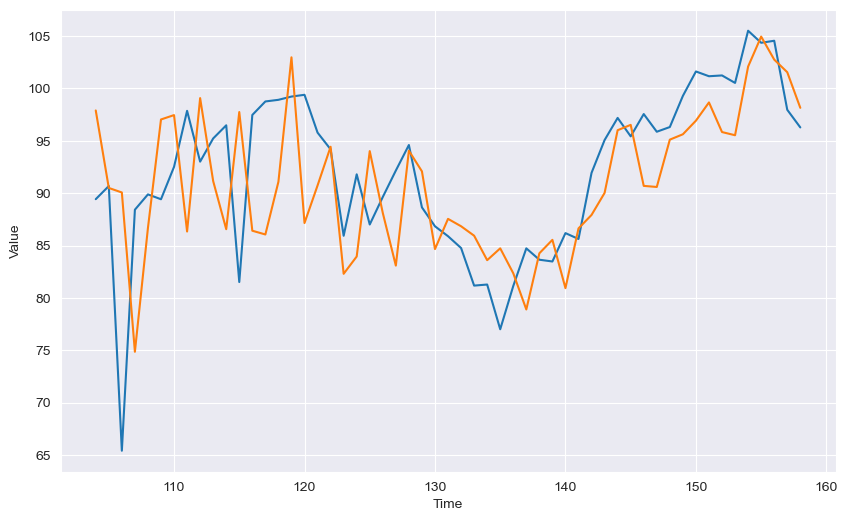

In [63]:
"""沒有搞懂"""
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:] #只有包含spliting time 以前的數據!!!
print("len(forecast_series) = ",len(forecast_series))

# Use the model to predict data points per window size
forecast_series = forecast_series.to_numpy()
print(type(forecast_series))
print("forecast_series.shape = ",forecast_series.shape)

for time in range(len(forecast_series) - window_size):
    #這裡把要forcast的序列和經緯度座標合併在一起
    #forcast_and_location = np.append(forecast_series[time:time + window_size],np.array(coordinates[0]) ) [np.newaxis]
    #print("type(forcast_and_location) = ",type(forcast_and_location))
    #print("forcast_and_location.shape = ",forcast_and_location.shape)
    #這裡把剛剛合併的資料丟到模型裡面做training，然後再把結果append給forcast序列(一個list)
    predict_ = model_baseline.predict(forecast_series[time:time + window_size][np.newaxis])
    forecast.append(predict_)
    print("predict_ = ",predict_)

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
print("time_valid = ",time_valid)
print("len(time_valid) = ",len(time_valid))
print("len(results) = ",len(results))
plot_series(time_valid, (x_valid, results))

In [64]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

48.650696
5.2783685
